<a href="https://www.kaggle.com/code/jendoll/titanic-w-explanation?scriptVersionId=169952160" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic - Machine Learning from Disaster

In this popular Kaggle challenge, we are going to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data. 
https://www.kaggle.com/competitions/titanic

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Analyzing the data
Let's take a look at our data to try and gain some insights
Let's start by taking a look at what the data looks like.  We can use the head() method to view the first 5 rows of data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Our testing data has all the same columns as the training data excpet for the 'Survived' column.  This is as expected since this is what we are trying to predict.

The Cabin column seems to have many missing values.  Let's see what percentage of the data is missing.

In [4]:
null_count = train_data['Cabin'].isnull().sum() # Summing up all missing values
total_count = train_data.shape[0] # The amount of rows in our data
print(f'{null_count/total_count * 100:.2f}%')

77.10%


Wow, that's a lot of missing data.  We can already begin the process of identifying which features are crucial for predicting chances of survival and which ones are not. Which columns do you believe should be omitted? I will give my answer to this later. 

Next, we will use the matplotlib library to visualize the data.

# Visualizing the Data
**Let's get some basic counts first.**

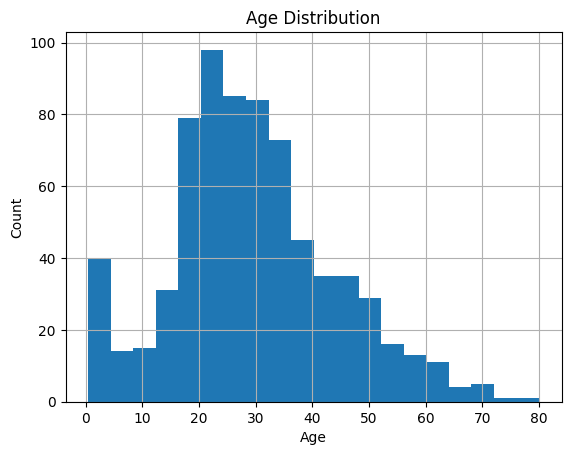

In [5]:
train_data.Age.hist(bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show();

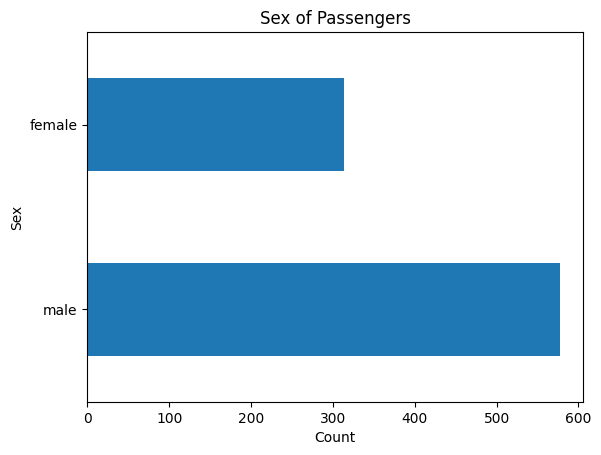

In [6]:
train_data.Sex.value_counts().plot(kind='barh');
plt.xlabel("Count");
plt.title("Sex of Passengers");

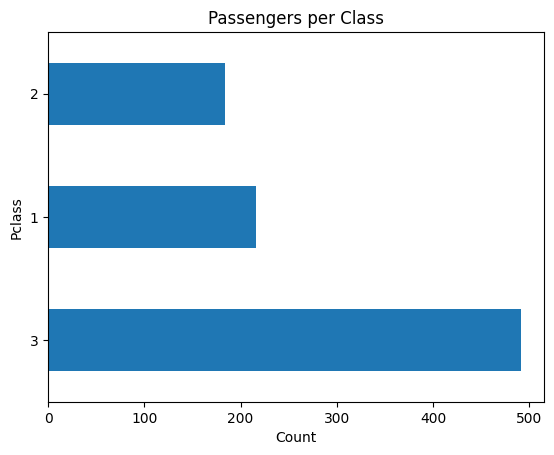

In [7]:
train_data['Pclass'].value_counts().plot(kind='barh');
plt.xlabel("Count");
plt.title("Passengers per Class");

**Now let's visualize the correlations between certain columns and the survival rates**

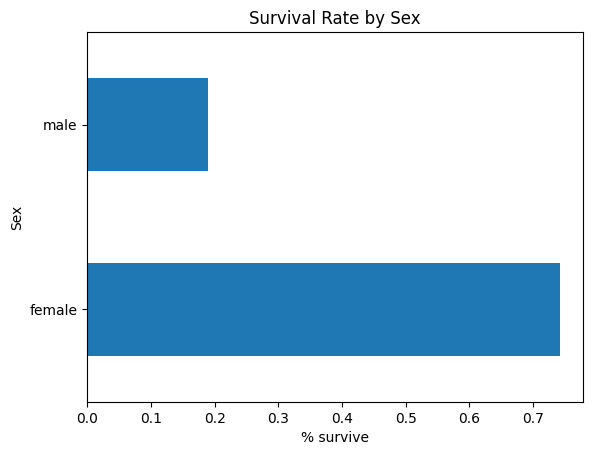

In [8]:
train_data.groupby('Sex').Survived.mean().plot(kind='barh').set_xlabel('% survive');
plt.title("Survival Rate by Sex");

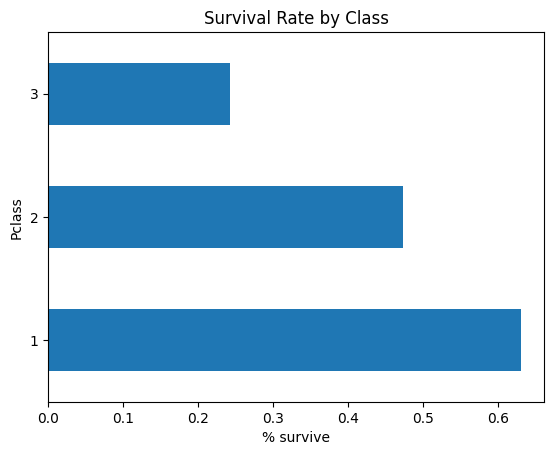

In [9]:
train_data.groupby('Pclass').Survived.mean().plot(kind='barh').set_xlabel('% survive');
plt.title('Survival Rate by Class');

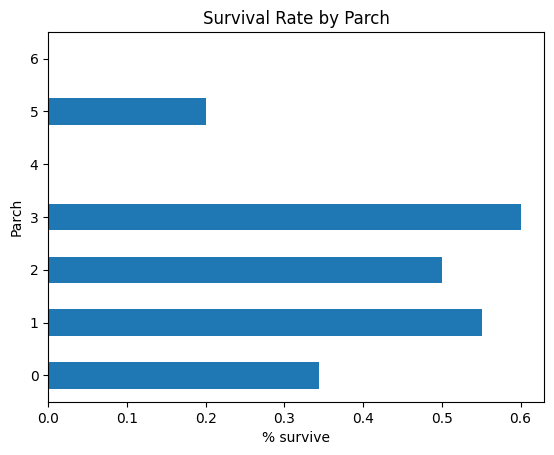

In [10]:
train_data.groupby('Parch').Survived.mean().plot(kind='barh').set_xlabel('% survive');
plt.title("Survival Rate by Parch");

I'm not sure what Parch is supposed to be, but it seems there is enough of a correlation to be useful.  Sex and Pclass are definietely good indicators of survival.

# Feature Selection
In the process of feature selection, it is imperative to carefully consider the inclusion or exclusion of specific features. In this context, the decision was made to omit PassengerId, Name, and Ticket from the analysis, as these variables merely serve as unique identifiers for each passenger and do not offer pertinent information for predicting survival outcomes.

With regard to the Cabin data, it is conceivable that passengers occupying particular cabins may have had varying survival probabilities, influenced by factors such as their proximity to lifeboats or the iceberg's impact point. While this data could potentially yield valuable predictive insights, its exclusion was deemed necessary due to the substantial proportion of missing values.

# Splitting the Data
Splitting the data into training and validation sets is a fundamental practice in machine learning and data science. This process is crucial for several reasons:

**Performance Estimation:** A validation set provides an unbiased evaluation of a model fit on the training dataset while tuning the model's hyperparameters. It helps to understand how well the model will generalize to an independent dataset.

**Generalization:** Overfitting occurs when a model learns the training data too closely, including its noise and outliers, which reduces its ability to generalize to new, unseen data. By using a validation set, you can monitor the model's performance and detect overfitting.

**Model Complexity Control:** The validation set helps in determining the right level of model complexity by preventing the model from being too simple (underfitting) or too complex (overfitting).

**Optimization:** Many machine learning algorithms have hyperparameters that need to be tuned for optimal performance. The validation set is used to evaluate different hyperparameter configurations and select the best-performing one.

**Error Detection:** A separate validation set helps in identifying data quality issues like missing values, outliers, or errors in the training data.

**Reliability:** Validating the model on a separate dataset ensures that the model is more robust and reliable, reducing the risk of making decisions based on a model that has not been thoroughly tested.

**Best Practices for Splitting Data:**

**Randomization:** It's important to randomly split the data to ensure that both the training and validation sets are representative of the overall dataset.

In [11]:
# Import the train_test_split function from scikit-learn
from sklearn.model_selection import train_test_split

# Define the target variable (what we want to predict)
# We are predicting the "Survived" column from the training data
y = train_data["Survived"]

# Define the feature columns that will be used for prediction
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Fare", "Embarked"]

# Use one-hot encoding to convert categorical columns into numerical form
# This is important because most machine learning algorithms require numerical input
X = pd.get_dummies(train_data[features])  # Training features
X_test = pd.get_dummies(test_data[features])  # Test features

# Split the dataset into training and validation sets
# The training set will be used to train the model
# The validation set will be used to evaluate the model's performance
# Setting random_state to a constant ensures reproducibility of the split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

# Creating a Function to Evaluate Model's Performance
In machine learning, evaluating the performance of a model is a crucial step to understand how well the model is performing on unseen data and to tune its hyperparameters for better results. To simplify this process and make it more efficient, we have created a Python function called get_mae. This function takes several parameters, including the number of trees (n_estimators), the maximum depth of the trees (max_depth), and the random state (random_state), along with the training and validation datasets (train_X, val_X, train_y, val_y).

Within the function, a Random Forest classifier is initialized with the specified parameters and then trained on the training dataset. Subsequently, the model makes predictions on the validation dataset, and the Mean Absolute Error (MAE) is calculated to quantify the model's performance. The MAE represents the average of the absolute differences between the actual and predicted values, providing a straightforward metric to evaluate the model's accuracy.

By using this get_mae function, we can easily assess the performance of a Random Forest model with different hyperparameter configurations and identify the optimal settings that yield the lowest MAE, thus enhancing the model's predictive accuracy and reliability.

In [12]:
# Import the RandomForestClassifier from scikit-learn
from sklearn.ensemble import RandomForestClassifier

# Import the mean_absolute_error function from scikit-learn
from sklearn.metrics import mean_absolute_error

# Define a function to calculate Mean Absolute Error (MAE) for a Random Forest model
def get_mae(n_estimators, max_depth, random_state, train_X, val_X, train_y, val_y):
    """
    Calculate Mean Absolute Error (MAE) for a Random Forest model.
    
    Parameters:
    - n_estimators: Number of trees in the Random Forest
    - max_depth: Maximum depth of the trees in the Random Forest
    - random_state: Seed used by the random number generator for reproducibility
    - train_X: Training features
    - val_X: Validation features
    - train_y: Training target variable
    - val_y: Validation target variable
    
    Returns:
    - mae: Mean Absolute Error of the model predictions on the validation set
    """
    
    # Initialize the Random Forest model with specified parameters
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    
    # Train the model on the training data
    model.fit(train_X, train_y)
    
    # Make predictions on the validation data
    preds_val = model.predict(val_X)
    
    # Calculate Mean Absolute Error (MAE) between the actual and predicted values
    mae = mean_absolute_error(val_y, preds_val)
    
    # Return the calculated MAE
    return mae

# Dealing with Missing Values
In the process of preparing our dataset for machine learning models, it's common to encounter missing values, which can hinder the performance and accuracy of the models. To address this issue, we use the SimpleImputer class from scikit-learn to fill in the missing values. In the provided code, we initialize a SimpleImputer object without specifying any parameters, which by default, replaces missing values with the mean value of the respective column.

First, the fit_transform() method is applied to the training features (train_X) to fit the imputer on the training data and transform it by filling the missing values. The resulting transformed data is then converted into a new DataFrame called final_X_train. Next, the transform() method is used on the validation features (val_X) using the imputer that was fitted on the training data. This ensures that the same transformation is applied consistently across both the training and validation datasets. The transformed validation data is then stored in a new DataFrame named final_X_valid.

By implementing this approach, we ensure that the dataset is complete and ready for training machine learning models, thereby enhancing the robustness and reliability of the subsequent model predictions.

In [13]:
# Import the SimpleImputer from scikit-learn
from sklearn.impute import SimpleImputer

# Initialize the SimpleImputer object
# This object will be used to fill missing values in the dataset
my_imputer = SimpleImputer()

# Fill missing values in the training features and create a new DataFrame
final_X_train = pd.DataFrame(my_imputer.fit_transform(train_X))

# Fill missing values in the validation features using the imputer fitted on the training data
# and create a new DataFrame
final_X_valid = pd.DataFrame(my_imputer.transform(val_X))

# Testing Different Hyperparameters to Find the Best Model
In machine learning, the performance of a model can be greatly influenced by its hyperparameters, such as the number of trees (n_estimators), the maximum depth of the trees (max_depth), and the random state (random_state). To determine the optimal combination of these hyperparameters and improve the predictive accuracy of our Random Forest model, we use a systematic approach to test different combinations.

The code defines lists of potential values for each hyperparameter: n_estimators_list with values [100, 150, 200], max_depth_list with values [6, 7, 8], and random_state_list with values [3, 4, 5]. Then, nested loops iterate through each combination of these hyperparameters. For each combination, the get_mae function is called to calculate the Mean Absolute Error (MAE) using the training and validation datasets (final_X_train, final_X_valid, train_y, val_y). The calculated MAE for each combination is stored in a list mae_list.

Finally, the code identifies the combination of hyperparameters that resulted in the lowest MAE using the min() function and prints the best hyperparameters along with the corresponding MAE. By executing this code, we systematically evaluate and compare different hyperparameter configurations to identify the optimal settings that yield the lowest MAE, thereby enhancing the performance and reliability of the Random Forest model for our dataset.

In [14]:
# Define lists of hyperparameters to be tested
n_estimators_list = [100, 150, 200]  # Number of trees in the Random Forest
max_depth_list = [6, 7, 8]  # Maximum depth of the trees in the Random Forest
random_state_list = [3, 4, 5]  # Seed used by the random number generator

# Initialize an empty list to store Mean Absolute Error (MAE) for each combination of hyperparameters
mae_list = []

# Loop through each combination of hyperparameters
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for random_state in random_state_list:
            # Calculate MAE using the get_mae function defined earlier
            mae = get_mae(n_estimators, max_depth, random_state, final_X_train, final_X_valid, train_y, val_y)
            
            # Uncomment the following line to print MAE for each combination of hyperparameters
            # print(f'No. Estimators: {n_estimators} \t Max Depth: {max_depth} \t Mean Absolute Error: {mae}')
            
            # Append the hyperparameters and corresponding MAE to the mae_list
            mae_list.append([n_estimators, max_depth, random_state, mae])

# Find the combination of hyperparameters that resulted in the lowest MAE
best_result = min(mae_list, key=lambda x: x[3])

# Print the best hyperparameters and the corresponding MAE
print(f"No. Estimators: {best_result[0]} \n Max Depth: {best_result[1]} \n Random State: {best_result[2]} Mean Absolute Error: {best_result[3]}")

No. Estimators: 100 
 Max Depth: 7 
 Random State: 3 Mean Absolute Error: 0.14798206278026907


# Making Final Predictions
In the final step of our machine learning pipeline, we utilize the optimized Random Forest model to make predictions on the test dataset. The previously identified best hyperparameters, including the number of trees (n_estimators), the maximum depth of the trees (max_depth), and the random state (random_state), are utilized to define the final Random Forest model. This model is then trained using the transformed training dataset (final_X_train) and the corresponding target variable (train_y).

Next, the missing values in the test features (X_test) are filled using the SimpleImputer object, and the transformed test data is converted to a DataFrame (final_X_test). Finally, the trained Random Forest model is employed to make predictions on the transformed test data, and the resulting predictions are stored in the predictions variable. By executing this final code block, we generate the final predictions for the test dataset, which can be utilized for evaluation and submission in the machine learning competition or project at hand.

In [15]:
# Define the final Random Forest model using the best hyperparameters identified earlier
model = RandomForestClassifier(n_estimators=best_result[0], max_depth=best_result[1], random_state=best_result[2])

# Train the final Random Forest model using the training data
model.fit(final_X_train, train_y)

# Fill missing values in the test features and create a new DataFrame
final_X_test = pd.DataFrame(my_imputer.fit_transform(X_test))

# Make predictions on the test data using the trained model
predictions = model.predict(final_X_test)

In [16]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Conclusion
In this notebook, we embarked on a comprehensive journey to develop and fine-tune a Random Forest model for predicting the survival of passengers aboard the Titanic. The initial steps involved data preprocessing, which included handling missing values and encoding categorical variables to prepare the data for machine learning algorithms. To ensure the integrity and reliability of our model, the dataset was split into training and validation sets, facilitating the evaluation of the model's performance on unseen data and preventing overfitting.

We then proceeded to optimize the Random Forest model by systematically testing various hyperparameter configurations. Utilizing a grid search approach, we evaluated combinations of the number of trees (n_estimators), the maximum depth of the trees (max_depth), and the random state (random_state), aiming to minimize the Mean Absolute Error (MAE) on the validation set. Through this rigorous optimization process, we identified the optimal hyperparameters that yielded the lowest MAE, enhancing the model's predictive accuracy and robustness.

In the final phase, we employed the optimized Random Forest model to make predictions on the test dataset, providing the final predictions that can be utilized for evaluation and submission in the machine learning competition or project. Throughout this notebook, we employed best practices in data preprocessing, hyperparameter tuning, and model evaluation to develop a reliable and accurate predictive model.

In conclusion, this notebook serves as a comprehensive guide to building and optimizing a Random Forest model for the Titanic dataset, showcasing the iterative process of data preprocessing, model tuning, and evaluation. The methodologies and techniques demonstrated herein can be applied to other classification tasks, making this notebook a valuable resource for aspiring data scientists and machine learning enthusiasts alike.

